# Datacamp

- https://app.datacamp.com/learn/courses/machine-learning-for-finance-in-python

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor

In [3]:
lng_df = yf.Tickers('LNG').history(period='10y', interval='1d', auto_adjust=True)['Close']
spy_df = yf.Tickers('SPY').history(period='10y', interval='1d', auto_adjust=True)['Close']
smlv_df = yf.Tickers('SMLV').history(period='10y', interval='1d', auto_adjust=True)['Close']

# self.data.index = self.data.index.tz_localize(None).to_period(self.frequency.name)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# Join 3 stock dataframes together
full_df = pd.concat([lng_df, spy_df, smlv_df], axis=1).dropna()

# Resample the full dataframe to monthly timeframe
monthly_df = full_df.resample('BMS').first()

# Calculate daily returns of stocks
returns_daily = full_df.pct_change()

# Calculate monthly returns of the stocks
returns_monthly = monthly_df.pct_change().dropna()
print(returns_monthly.tail())

Ticker                          LNG       SPY      SMLV
Date                                                   
2024-07-01 00:00:00+00:00  0.077642  0.036566  0.007501
2024-08-01 00:00:00+00:00  0.038595 -0.004273  0.121559
2024-09-02 00:00:00+00:00  0.019817  0.016703  0.017697
2024-10-01 00:00:00+00:00 -0.008640  0.033119 -0.017285
2024-11-01 00:00:00+00:00  0.034473  0.004256  0.025702


In [5]:
covariances = {}
rtd_idx = returns_daily.index
for i in returns_monthly.index:    
    # Mask daily returns for each month and year, and calculate covariance
    mask = (rtd_idx.month == i.month) & (rtd_idx.year == i.year)
    
    # Use the mask to get daily returns for the current month and year of monthy returns index
    covariances[i] = returns_daily[mask].cov()

print(covariances[i])

Ticker       LNG       SPY      SMLV
Ticker                              
LNG     0.000359  0.000120  0.000412
SPY     0.000120  0.000102  0.000401
SMLV    0.000412  0.000401  0.002100


In [6]:
portfolio_returns, portfolio_volatility, portfolio_weights = {}, {}, {}

sample_size = 1000

# Get portfolio performances at each month
for date in sorted(covariances.keys()):
    cov = covariances[date]
    for portfolio in range(sample_size):
        weights = np.random.random(len(full_df.columns))
        weights /= np.sum(weights) # /= divides weights by their sum to normalize
        returns = np.dot(weights, returns_monthly.loc[date])
        volatility = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
        portfolio_returns.setdefault(date, []).append(returns)
        portfolio_volatility.setdefault(date, []).append(volatility)
        portfolio_weights.setdefault(date, []).append(weights)
        
print(portfolio_weights[date][0])

[0.18112464 0.27024278 0.54863259]


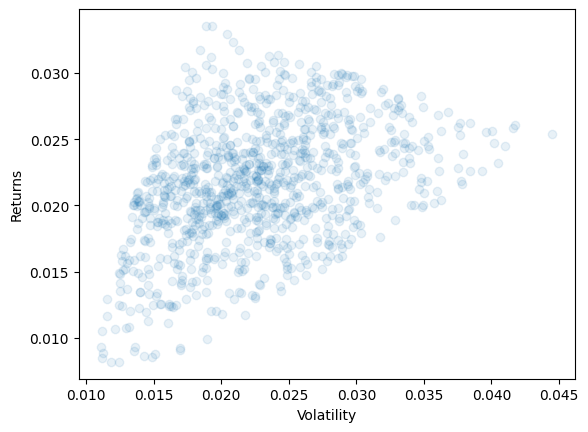

In [7]:
# Get latest date of available data
date = sorted(covariances.keys())[-1]  

# Plot efficient frontier
# warning: this can take at least 10s for the plot to execute...
plt.scatter(x=portfolio_volatility[date], y=portfolio_returns[date],  alpha=0.1)
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [8]:
# Empty dictionaries for sharpe ratios and best sharpe indexes by date
sharpe_ratio, max_sharpe_idxs = {}, {}

# Loop through dates and get sharpe ratio for each portfolio
for date in portfolio_returns.keys():
    for i, ret in enumerate(portfolio_returns[date]):
    
        # Divide returns by the volatility for the date and index, i
        sharpe_ratio.setdefault(date, []).append(ret / portfolio_volatility[date][i])

    # Get the index of the best sharpe ratio for each date
    max_sharpe_idxs[date] = np.argmax(sharpe_ratio[date])

print(portfolio_returns[date][max_sharpe_idxs[date]])

0.033513758237727835


In [9]:
# Calculate exponentially-weighted moving average of daily returns
ewma_daily = returns_daily.ewm(span=30).mean()

# Resample daily returns to first business day of the month with the first day for that month
ewma_monthly = ewma_daily.resample('BMS').first()

# Shift ewma for the month by 1 month forward so we can use it as a feature for future predictions 
ewma_monthly = ewma_monthly.shift(1).dropna()

print(ewma_monthly.iloc[-1])

Ticker
LNG     0.000430
SPY     0.001076
SMLV   -0.000280
Name: 2024-11-01 00:00:00+00:00, dtype: float64


In [10]:
targets, features = [], []

# Create features from price history and targets as ideal portfolio
for date, ewma in ewma_monthly.iterrows():

    # Get the index of the best sharpe ratio
    best_idx = max_sharpe_idxs[date]
    targets.append(portfolio_weights[date][best_idx])
    features.append(ewma)  # add ewma to features

targets = np.array(targets)
features = np.array(features)
print(targets[-5:])

[[0.6305184  0.36241847 0.00706313]
 [0.04172927 0.00589379 0.95237694]
 [0.54197192 0.45168867 0.00633941]
 [0.14027508 0.85305509 0.00666983]
 [0.94033277 0.0203365  0.03933074]]


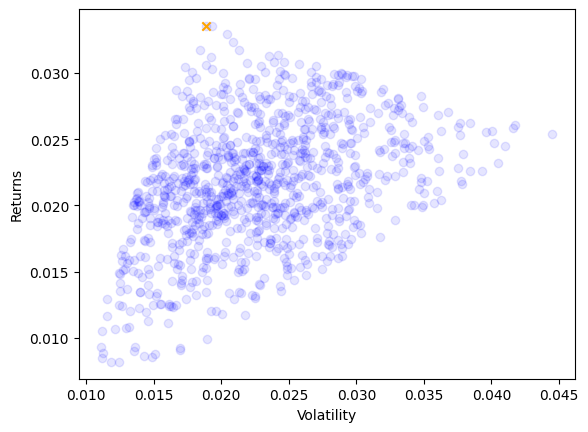

In [11]:
# Get most recent (current) returns and volatility
date = sorted(covariances.keys())[-1]
cur_returns = portfolio_returns[date]
cur_volatility = portfolio_volatility[date]

# Plot efficient frontier with sharpe as point
plt.scatter(x=cur_volatility, y=cur_returns, alpha=0.1, color='blue')
best_idx = max_sharpe_idxs[date]

# Place an orange "X" on the point with the best Sharpe ratio
plt.scatter(x=cur_volatility[best_idx], y=cur_returns[best_idx], marker='x', color='orange')
plt.xlabel('Volatility')
plt.ylabel('Returns')
plt.show()

In [12]:
# Make train and test features
train_size = int(0.85 * features.shape[0])
train_features = features[:train_size]
test_features = features[train_size:]
train_targets = targets[:train_size]
test_targets = targets[train_size:]

# Fit the model and check scores on train and test
rfr = RandomForestRegressor(n_estimators=300, random_state=42)
rfr.fit(train_features, train_targets)
print(rfr.score(train_features, train_targets))
print(rfr.score(test_features, test_targets))

0.8396537093609245
-0.13064266175159592


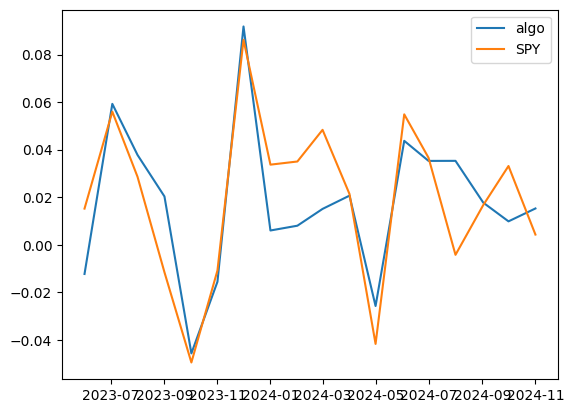

In [13]:
# Get predictions from model on train and test
train_predictions = rfr.predict(train_features)
test_predictions = rfr.predict(test_features)

# Calculate and plot returns from our RF predictions and the SPY returns
test_returns = np.sum(returns_monthly.iloc[train_size:] * test_predictions, axis=1)
plt.plot(test_returns, label='algo')
plt.plot(returns_monthly['SPY'].iloc[train_size:], label='SPY')
plt.legend()
plt.show()

In [14]:
# Calculate the effect of our portfolio selection on a hypothetical $1k investment
cash = 1000
algo_cash, spy_cash = [cash], [cash]  # set equal starting cash amounts
for r in test_returns:
    cash *= 1 + r
    algo_cash.append(cash)

# Calculate performance for SPY
cash = 1000  # reset cash amount
for r in returns_monthly['SPY'].iloc[train_size:]:
    cash *= 1 + r
    spy_cash.append(cash)

print('algo returns:', (algo_cash[-1] - algo_cash[0]) / algo_cash[0])
print('SPY returns:', (spy_cash[-1] - spy_cash[0]) / spy_cash[0])

algo returns: 0.357101124855378
SPY returns: 0.40300076208973884


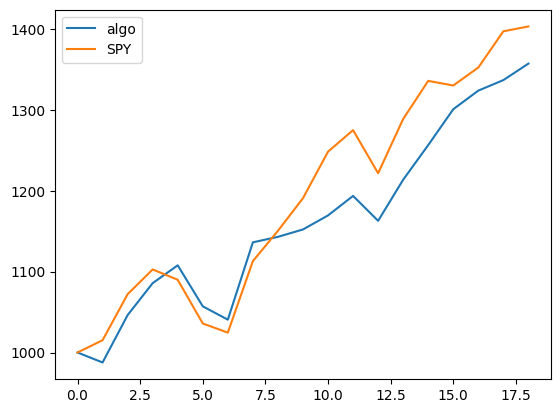

In [15]:
# Plot the algo_cash and spy_cash to compare overall returns
plt.plot(algo_cash, label='algo')
plt.plot(spy_cash, label='SPY')
plt.legend()  # show the legend
plt.show()